# SITCOM-797

Here is what was requested:

To analyze the positioning system after a slew, create plots for the mirror

- decentering (X and Y)
- mirror tilt (RX, RY, RY)
- piston
- Create a histogram for each parameter for a configurable time period.

Include the limits in all plots:

* the mirror decenters at less than +/- 6 micrometer
* mirror tilt less than +/- 24 e-6 degree
* piston less than +/- 1 micrometer


### Prepare Notebook

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from astropy import time
from astropy import units as u
import matplotlib.dates as mdates

from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient

In [3]:
# Select data from a given date
#dayObs = 20230627
dayObs = 20230628
eventMaker = TMAEventMaker()
events = eventMaker.getEvents(dayObs)

# Get lists of slew and track events
slews = [e for e in events if e.type==TMAState.SLEWING]
tracks = [e for e in events if e.type==TMAState.TRACKING]
print(f'Found {len(slews)} slews and {len(tracks)} tracks')

Found 1183 slews and 0 tracks


In [4]:
# create a client to retrieve datasets in the EFD database
client = makeEfdClient()

In [5]:
pos_columns = [a + "Position" for a in "xyz"]
rot_columns = [a + "Rotation" for a in "xyz"]
all_columns = pos_columns + rot_columns

## Analysis

 * Loop over all the slews
 * Compute mean, sigma and maximum difference w.r.t. the first values
 * Store results in a dataframe in order to plot them later

In [6]:
# define small amount of time to check mirror position before and after the slews
delta_t = 1
dt_begin = time.TimeDelta(-delta_t, format='sec')
dt_end = time.TimeDelta(delta_t, format='sec')

results = pd.DataFrame(columns=["i_slew", "duration", "x_mean", "y_mean", "z_mean", "x_sigma", "y_sigma", "z_sigma", 
                                "R_x_mean", "R_y_mean", "R_z_mean", "Rx_sigma", "Ry_sigma", "Rz_sigma",
                                "dx_max", "dy_max", "dz_max", "R_dx_max", "R_dy_max", "R_dz_max",
                                "x_before", "y_before", "z_before", "R_x_before", "R_y_before", "R_z_before",
                                "x_after", "y_after", "z_after", "R_x_after", "R_y_after", "R_z_after",
                                "start_ele", "end_ele", "start_azi", "end_azi", "speed_ele"])


for i_slew, slew in enumerate(slews):
    #print(i_slew)
    # Get ims data
    df_ims = getEfdData(client, 'lsst.sal.MTM1M3.imsData', event=slew)
    if len(df_ims) == 0:
        print(f"No data for slew number: {i_slew}")
        continue 
        
    df_ims = df_ims[all_columns]

    # Convert meter to milimeter to make is easier to analyse
    df_ims[pos_columns] = df_ims[pos_columns] * 1e3
    
    # get ims data before and after the slew
    df_ims_before = getEfdData(client, 'lsst.sal.MTM1M3.imsData', begin=slew.begin, timespan=dt_begin)
    if len(df_ims_before) == 0:
        print(f"No data before slew number: {i_slew}")
        continue 
    df_ims_before = df_ims_before[all_columns]
    df_ims_before[pos_columns] = df_ims_before[pos_columns]*u.m.to(u.mm)
    
    df_ims_after = getEfdData(client, 'lsst.sal.MTM1M3.imsData', begin=slew.end, timespan=dt_end)
    if len(df_ims_before) == 0:
        print(f"No data after slew number: {i_slew}")
        continue 
    df_ims_after = df_ims_after[all_columns]
    df_ims_after[pos_columns] = df_ims_after[pos_columns]*u.m.to(u.mm)
    
    mean = {}
    sigma = {}
    max_diff = {}
    mean_before={}
    mean_after = {}
    for col in all_columns:
        mean[col] = np.mean(df_ims[col])
        sigma[col] = np.std(df_ims[col])
        t0 = df_ims.index[0]
        max_diff[col] = np.max(np.abs(df_ims[t0:t0][col][0]-df_ims[col]))
        
        mean_before[col] = np.mean(df_ims_before[col])
        mean_after[col] = np.mean(df_ims_after[col])
        
    # get elevation data
    df_ele = getEfdData(client, 'lsst.sal.MTMount.elevation', event= slew)
    pos_ele = df_ele["actualPosition"]
    start_ele = pos_ele[pos_ele.index[0]]
    end_ele = pos_ele[pos_ele.index[len(pos_ele)-1]]
    # get speed
    speed_ele = np.mean(df_ele["demandVelocity"])
    
    # get azimuth data
    df_azi = getEfdData(client, 'lsst.sal.MTMount.azimuth', event= slew)
    pos_azi = df_azi["actualPosition"]
    start_azi = pos_azi[pos_azi.index[0]]
    end_azi = pos_azi[pos_azi.index[len(pos_azi)-1]]
        
    # Store computed values in dataframe
    vect = [[i_slew], [slew.duration], [mean[i] for i in pos_columns], [sigma[i] for i in pos_columns], [mean[i] for i in rot_columns], [sigma[i] for i in rot_columns],
            [max_diff[i] for i in pos_columns], [max_diff[i] for i in rot_columns],
            [mean_before[i] for i in pos_columns], [mean_before[i] for i in rot_columns], [mean_after[i] for i in pos_columns], [mean_after[i] for i in rot_columns],
            [start_ele], [end_ele], [start_azi], [end_azi], [speed_ele]]
    flat_vect = [item for sublist in vect for item in sublist]
    results = pd.concat([results, pd.DataFrame([flat_vect], columns=results.columns)], ignore_index=True)
        

In [ ]:
results

Found 0 outliers xPosition (limit: 100 microns)
Found 72 outliers xRotation (limit: 0.55 arcsec)
Found 1 outliers yPosition (limit: 100 microns)
Found 45 outliers yRotation (limit: 0.55 arcsec)
Found 1 outliers zPosition (limit: 100 microns)
Found 2 outliers zRotation (limit: 0.55 arcsec)


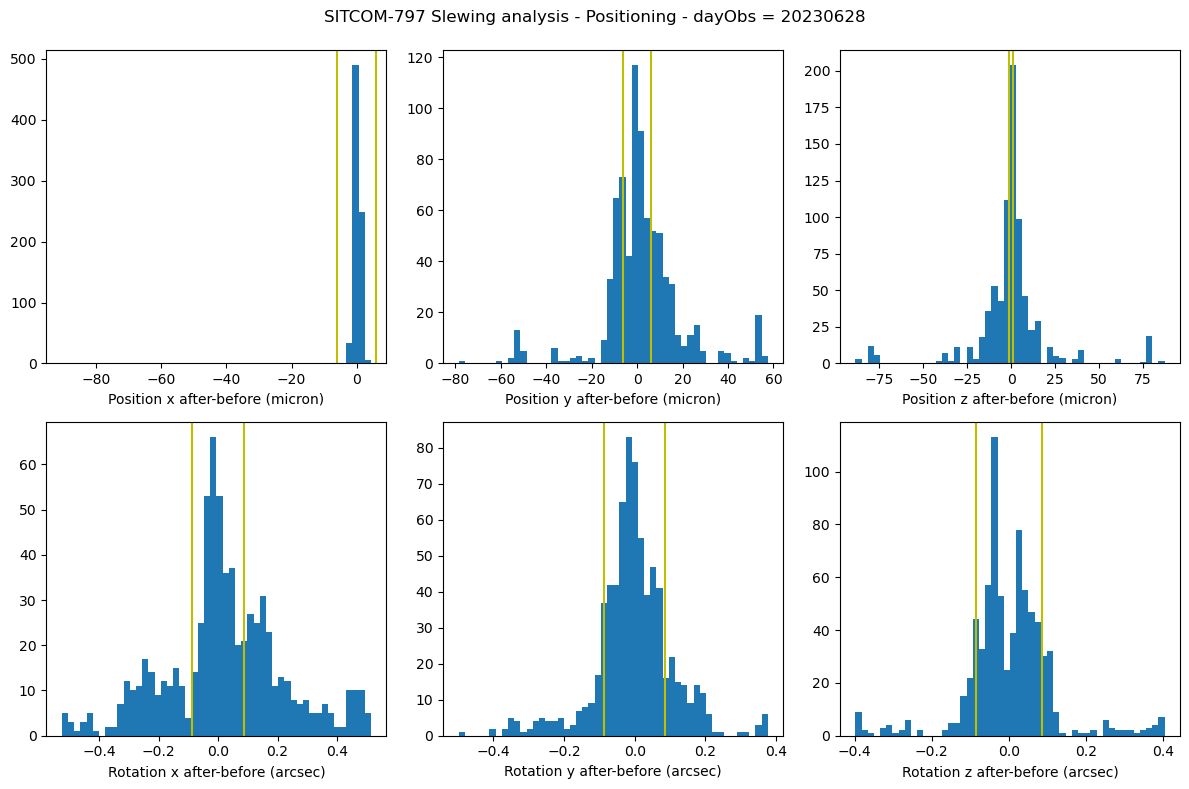

In [7]:
# Plot results (histograms)
%matplotlib inline

locator = mdates.AutoDateLocator(minticks=3, maxticks=3)
formatter = mdates.ConciseDateFormatter(locator)

axes = "xyz"

# limit on position (micron) or rotation (arcsec) for ouliers
out_limit_pos = 100
out_limit_rot = 0.55 

title = f"SITCOM-797 Slewing analysis - Positioning - dayObs = {dayObs}"
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(12, 8))

# Check whether the TMA actually move in elevation
mask_move = abs(results["speed_ele"]) > 0.05

for i in range(3):
    diff = (results[f"{axes[i]}_after"] - results[f"{axes[i]}_before"])*u.mm.to(u.micron)
    mask_out = np.abs(diff) < out_limit_pos
    print(f"Found {len(results)-np.sum(mask_out)} outliers {axes[i]}Position (limit: {out_limit_pos} microns)")
    mask = mask_out & mask_move
    axs[0][i].hist(diff[mask], bins=50)
    axs[0][i].set_xlabel(f"Position {axes[i]} after-before (micron)")
    
    R_diff = (results[f"R_{axes[i]}_after"] - results[f"R_{axes[i]}_before"])*u.degree.to(u.arcsec)
    mask_out = np.abs(R_diff) < out_limit_rot
    print(f"Found {len(results)-np.sum(mask_out)} outliers {axes[i]}Rotation (limit: {out_limit_rot} arcsec)")
    mask = mask_out & mask_move
    axs[1][i].hist(R_diff[mask], bins=50)
    axs[1][i].set_xlabel(f"Rotation {axes[i]} after-before (arcsec)")
    
    if axes[i] in ["x", "y"]:
        axs[0][i].axvline(6, color='y')
        axs[0][i].axvline(-6, color='y')
        axs[1][i].axvline(0.0864, color='y')
        axs[1][i].axvline(-0.0864, color='y')
    else:
        axs[0][i].axvline(1, color='y')
        axs[0][i].axvline(-1, color='y')
        axs[1][i].axvline(0.0864, color='y')
        axs[1][i].axvline(-0.0864, color='y')
    
fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.93)

Found 0 outliers xPosition (limit: 100 microns)
Found 72 outliers xRotation (limit: 0.55 arcsec)
Found 1 outliers yPosition (limit: 100 microns)
Found 45 outliers yRotation (limit: 0.55 arcsec)
Found 1 outliers zPosition (limit: 100 microns)
Found 2 outliers zRotation (limit: 0.55 arcsec)


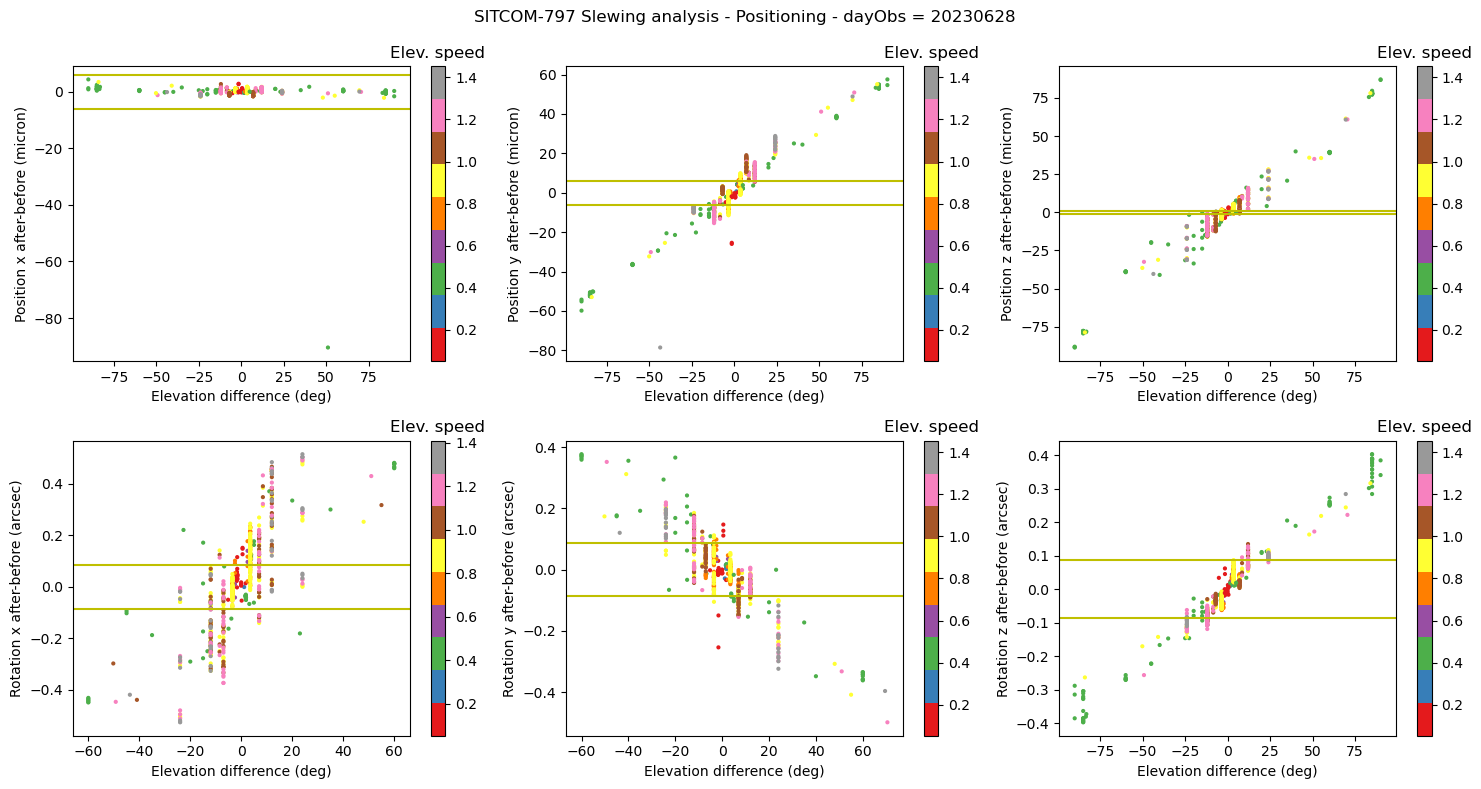

In [8]:
# Plot results (scatter plots)
locator = mdates.AutoDateLocator(minticks=3, maxticks=3)
formatter = mdates.ConciseDateFormatter(locator)

#cm = plt.cm.get_cmap('RdYlBu')
cm = plt.cm.get_cmap('Set1')

axes = [ "x", "y", "z"]

# limit on position (micron) or rotation (arcsec) for ouliers
out_limit_pos = 100
out_limit_rot = 0.55

title = f"SITCOM-797 Slewing analysis - Positioning - dayObs = {dayObs}"
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(15, 8))

# Check whether the TMA actually move in elevation
#mask_move = abs(results["end_ele"] - results["start_ele"]) > 1
mask_move = abs(results["speed_ele"]) > 0.05

diff_ele = results["end_ele"] - results["start_ele"]

for i in range(3):
    diff = (results[f"{axes[i]}_after"] - results[f"{axes[i]}_before"])*u.mm.to(u.micron)
    mask_out = np.abs(diff) < out_limit_pos
    print(f"Found {len(results)-np.sum(mask_out)} outliers {axes[i]}Position (limit: {out_limit_pos} microns)")
    mask = mask_out & mask_move
    im = axs[0][i].scatter(diff_ele[mask], diff[mask], c=abs(results["speed_ele"][mask]), s=4, cmap=cm)
    axs[0][i].set_xlabel("Elevation difference (deg)")
    axs[0][i].set_ylabel(f"Position {axes[i]} after-before (micron)")
    clb = fig.colorbar(im, ax=axs[0][i])
    clb.ax.set_title('Elev. speed')

    R_diff = (results[f"R_{axes[i]}_after"] - results[f"R_{axes[i]}_before"])*u.degree.to(u.arcsec)
    mask_out = np.abs(R_diff) < out_limit_rot
    print(f"Found {len(results)-np.sum(mask_out)} outliers {axes[i]}Rotation (limit: {out_limit_rot} arcsec)")
    mask = mask_out & mask_move
    im = axs[1][i].scatter(diff_ele[mask], R_diff[mask], c=abs(results["speed_ele"][mask]), s=4, cmap=cm)
    axs[1][i].set_xlabel("Elevation difference (deg)")
    axs[1][i].set_ylabel(f"Rotation {axes[i]} after-before (arcsec)")
    clb = fig.colorbar(im, ax=axs[1][i])
    clb.ax.set_title('Elev. speed')
    
    if axes[i] in ["x", "y"]:
        axs[0][i].axhline(6, color='y')
        axs[0][i].axhline(-6, color='y')
        axs[1][i].axhline(0.0864, color='y')
        axs[1][i].axhline(-0.0864, color='y')
    else:
        axs[0][i].axhline(1, color='y')
        axs[0][i].axhline(-1, color='y')
        axs[1][i].axhline(0.0864, color='y')
        axs[1][i].axhline(-0.0864, color='y')
    
fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.91)

Found 1 outliers for pair xy (limit: 100 microns)
Found 72 outliers for pair xy (limit: 0.55 arcsec)
Found 1 outliers for pair yz (limit: 100 microns)
Found 46 outliers for pair yz (limit: 0.55 arcsec)
Found 1 outliers for pair xz (limit: 100 microns)
Found 73 outliers for pair xz (limit: 0.55 arcsec)


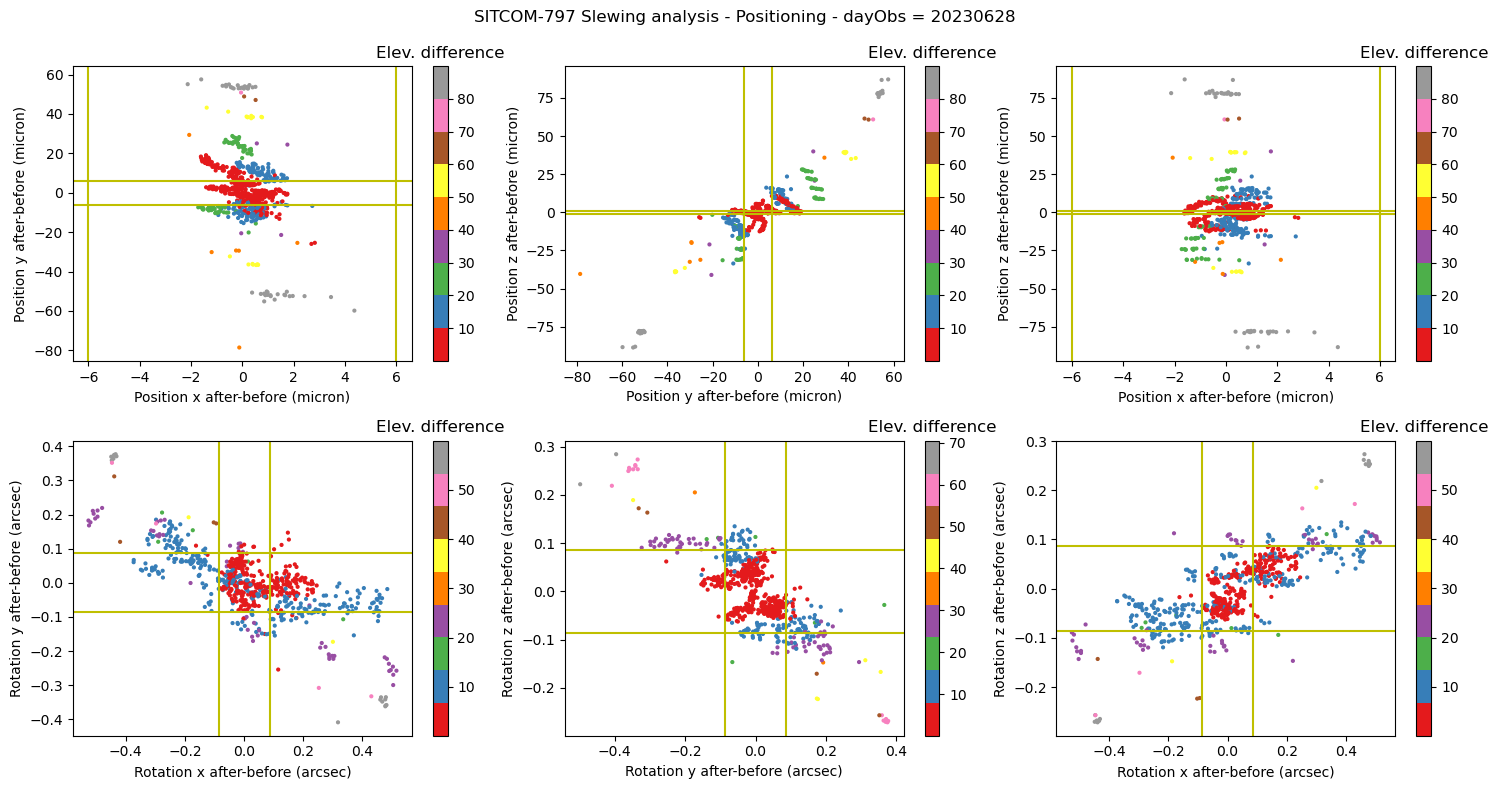

In [13]:
# Plot results (scatter plots)
locator = mdates.AutoDateLocator(minticks=3, maxticks=3)
formatter = mdates.ConciseDateFormatter(locator)

#cm = plt.cm.get_cmap('RdYlBu')
cm = plt.cm.get_cmap('Set1')

pairs = [ "xy", "yz", "xz"]

# limit on position (micron) or rotation (arcsec) for ouliers
out_limit_pos = 100
out_limit_rot = 0.55

title = f"SITCOM-797 Slewing analysis - Positioning - dayObs = {dayObs}"
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(15, 8))

# Check whether the TMA actually move in elevation
mask_move = abs(results["speed_ele"]) > 0.05

# Elevation change
diff_ele = results["end_ele"] - results["start_ele"]

for i in range(3):
    pair = pairs[i]
    
    # Positions
    diff_1 = (results[f"{pair[0]}_after"] - results[f"{pair[0]}_before"])*u.mm.to(u.micron)
    diff_2 = (results[f"{pair[1]}_after"] - results[f"{pair[1]}_before"])*u.mm.to(u.micron)
    mask_out = (np.abs(diff_1) < out_limit_pos) & (np.abs(diff_2) < out_limit_pos)
    print(f"Found {len(results)-np.sum(mask_out)} outliers for pair {pair} (limit: {out_limit_pos} microns)")
    mask = mask_out & mask_move
    im = axs[0][i].scatter(diff_1[mask], diff_2[mask], c=abs(diff_ele[mask]), s=4, cmap=cm)
    axs[0][i].set_xlabel(f"Position {pair[0]} after-before (micron)")
    axs[0][i].set_ylabel(f"Position {pair[1]} after-before (micron)")
    clb = fig.colorbar(im, ax=axs[0][i])
    clb.ax.set_title('Elev. difference')
    
    if pair[0] == 'x' or pair[0] == 'y':
        axs[0][i].axvline(6, color='y')
        axs[0][i].axvline(-6, color='y')
    else:
        axs[0][i].axvline(1, color='y')
        axs[0][i].axvline(-1, color='y')
        
    if pair[1] == 'x' or pair[1] == 'y':
        axs[0][i].axhline(6, color='y')
        axs[0][i].axhline(-6, color='y')
    else:
        axs[0][i].axhline(1, color='y')
        axs[0][i].axhline(-1, color='y')
    
    # Rotations
    R_diff_1 = (results[f"R_{pair[0]}_after"] - results[f"R_{pair[0]}_before"])*u.degree.to(u.arcsec)
    R_diff_2 = (results[f"R_{pair[1]}_after"] - results[f"R_{pair[1]}_before"])*u.degree.to(u.arcsec)
    mask_out = (np.abs(R_diff_1) < out_limit_rot) & (np.abs(R_diff_2) < out_limit_rot)
    print(f"Found {len(results)-np.sum(mask_out)} outliers for pair {pair} (limit: {out_limit_rot} arcsec)")
    mask = mask_out & mask_move
    im = axs[1][i].scatter(R_diff_1[mask], R_diff_2[mask], c=abs(diff_ele[mask]), s=4, cmap=cm)
    axs[1][i].set_xlabel(f"Rotation {pair[0]} after-before (arcsec)")
    axs[1][i].set_ylabel(f"Rotation {pair[1]} after-before (arcsec)")
    clb = fig.colorbar(im, ax=axs[1][i])
    clb.ax.set_title('Elev. difference')
    
    axs[1][i].axhline(0.0864, color='y')
    axs[1][i].axhline(-0.0864, color='y')
    axs[1][i].axvline(0.0864, color='y')
    axs[1][i].axvline(-0.0864, color='y')
    
fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.91)